In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import sys
import torch as t
from torch import nn, Tensor
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from dataclasses import dataclass
import numpy as np
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple, Dict
from functools import partial
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
from rich.table import Table
from IPython.display import display, HTML
from pathlib import Path
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Make sure exercises are in the path
sys.path.append(str(Path.cwd().parent))
from plotly_utils import imshow, line, hist
from utils import (
    plot_features_in_2d,
    plot_features_in_Nd,
    plot_features_in_Nd_discrete,
    plot_correlated_features,
    plot_feature_geometry,
    frac_active_line_plot,
)


device = t.device("cuda" if t.cuda.is_available() else "cpu")

sys.path.append('../Models_of_superposition/')
from superposition_lib import Config, get_angle, create_mask_from_group_members, create_diagonal_mask,Model

from sae_lib import AutoEncoder, AutoEncoderConfig
from sklearn.decomposition import PCA



In [2]:
i_selected_parameter = 20

dicts_of_models = t.load("../Models_of_superposition/data/experiment_1/model.pth")
feature_probability = t.load("../Models_of_superposition/data/experiment_1/feature_probability.pth")[i_selected_parameter]
group_size = 5
inner_goup_distance = 0.1
p_transfer = 0.9
n_instances = 1
n_features = dicts_of_models["W"].shape[2]
n_hidden = dicts_of_models["W"].shape[1]
groupings =[ [dict(members=list(range(i, i+group_size)), semantic_distance=inner_goup_distance, p_transfer = p_transfer) for i in range(0, n_features, group_size)] for _ in range(n_instances)]
cfg = Config(
    n_instances = n_instances,
    n_features = n_features,
    n_hidden = n_hidden,
)

model = Model(
    cfg = cfg,
    device = device,
    feature_probability = feature_probability,
    groupings = groupings,
)
model.W = t.nn.Parameter(dicts_of_models["W"][i_selected_parameter][None])
model.b = t.nn.Parameter(dicts_of_models["b_final"][i_selected_parameter][None])

In [3]:
feature_probability

tensor([0.3733])

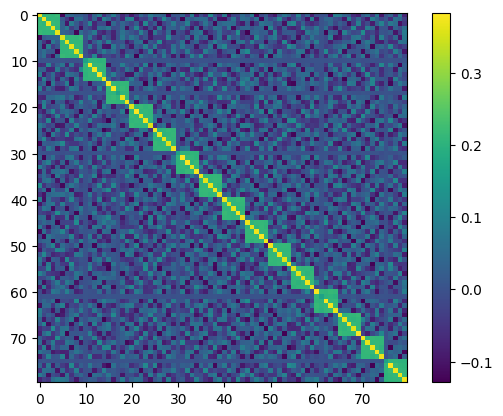

In [5]:
weights=  model.W
def WtW(weights: t.Tensor) -> t.Tensor:
    return einops.einsum(
        weights,
        weights,
        "instances hidden feats_i, instances hidden feats_j -> instances feats_i feats_j",)
wtw = WtW(weights).detach().numpy()
plt.imshow(wtw[0])
plt.colorbar()	

In [6]:
synthetic_batch = t.eye(n_features)
synthetic_hidden_activations = t.einsum("...if,ihf->...ih", synthetic_batch, model.W)
differences = synthetic_hidden_activations[:, None, : ] - synthetic_hidden_activations[None, :, :]
squared_distances = (differences ** 2).sum(-1)

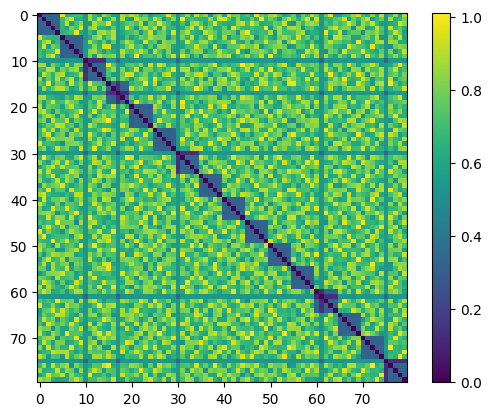

In [7]:
plt.imshow(squared_distances.detach().numpy())
# add a colorbar
plt.colorbar()


In [13]:
#model.feature_probability= t.ones_like(model.feature_probability) * 0.01

In [9]:
SAE_config = AutoEncoderConfig(5,20,80,l1_coeff = 0.01)
SAE = AutoEncoder(SAE_config)

In [ ]:
#model.feature_probability = t.ones_like(model.feature_probability) * 0.0

In [10]:
data_log, loss_log = SAE.optimize(model, steps = 2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'L2 loss')

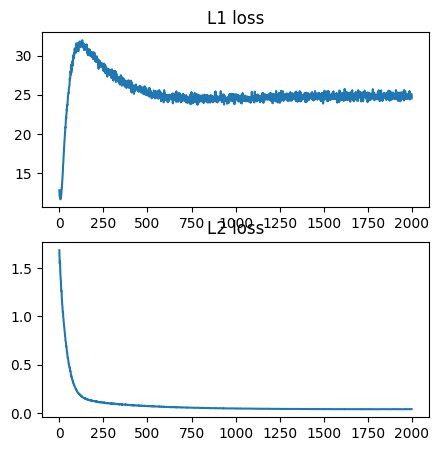

In [11]:
fig, ax = plt.subplots(2,1, figsize = (5,5))
ax[0].plot(loss_log["l1_loss"])
ax[0].set_title("L1 loss")
ax[1].plot(loss_log["l2_loss"])
ax[1].set_title("L2 loss")

In [12]:
batch_size = 10000
features = model.generate_batch(batch_size)
h = einops.einsum(
    features,
    model.W,
    "batch instances feats, instances hidden feats -> batch instances hidden",
)

h_cent = h - SAE.b_dec
acts = einops.einsum(
    h_cent,
    SAE.W_enc,
    "batch_size n_instances n_input_ae, n_instances n_input_ae n_hidden_ae -> batch_size n_instances n_hidden_ae",
)
acts = F.relu(acts + SAE.b_enc)

# Compute reconstructed input
h_reconstructed = (
    einops.einsum(
        acts,
        SAE.normalize_and_return_W_dec(),
        "batch_size n_instances n_hidden_ae, n_instances n_hidden_ae n_input_ae -> batch_size n_instances n_input_ae",
    )
    + SAE.b_dec
)
reconstructed_features_no_sae = F.relu(t.einsum("...ih,ihf->...if", h, model.W) + model.b_final)
reconstructed_features_with_sae = F.relu(t.einsum("...ih,ihf->...if", h_reconstructed, model.W) + model.b_final)

In [13]:
n_active = acts.mean(0).detach().numpy()
activity_mask = n_active > 0.15

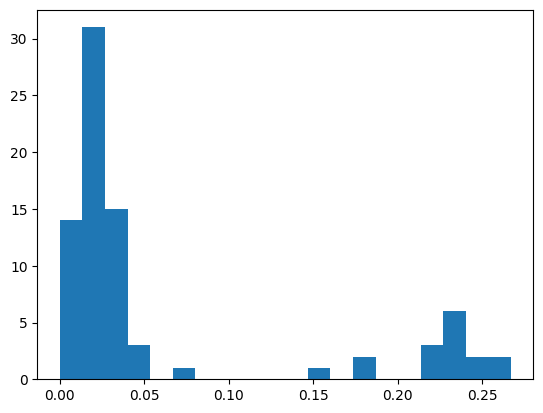

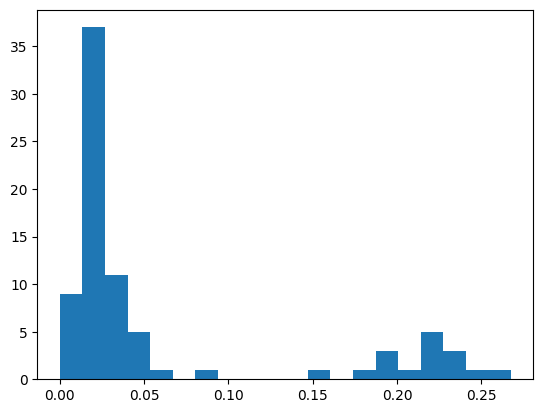

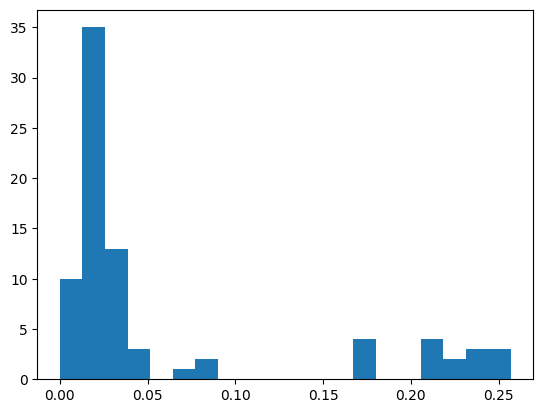

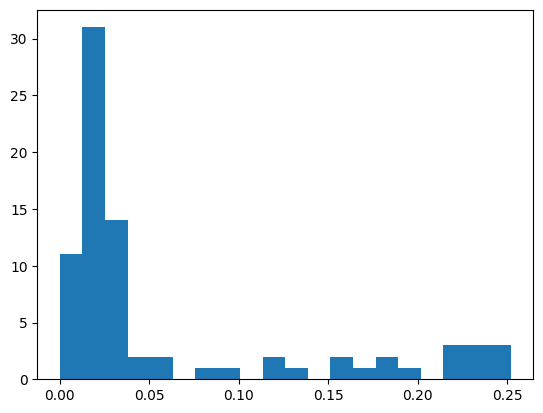

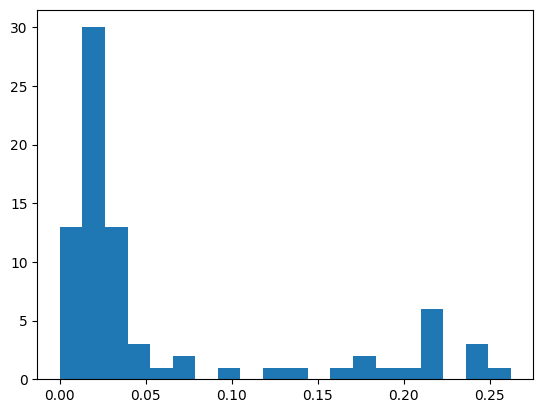

In [14]:
for active_in_instance in n_active:
    #make a histogram of the numbers in active_in_instance
    plt.hist(active_in_instance, bins = 20)
    plt.show()

In [15]:
h = einops.rearrange(model.W, "a b c -> c a b")- SAE.b_dec[None,:,:]
acts = einops.einsum( h, SAE.W_enc,"feature instance compressed, instance compressed decompressed -> instance feature decompressed")
acts = F.relu(acts + SAE.b_enc[None,:,None])[0]


In [16]:
acts.shape

torch.Size([5, 80, 80])

In [17]:
SAE.W_enc.shape[-1]

80

In [18]:
onehots = t.eye(SAE.W_enc.shape[-1])
onehots = einops.repeat(onehots, "b c -> (batch_size) b c", batch_size = SAE.W_enc.shape[0])

In [19]:
onehots.shape

torch.Size([5, 80, 80])

In [20]:
onehots = t.eye(SAE.W_enc.shape[-1])
onehots = einops.repeat(onehots, "b c ->b (instance) c", instance = SAE.W_enc.shape[0])
h_onehots = (
    einops.einsum(
       onehots,
        SAE.normalize_and_return_W_dec(),
        "batch_size n_instances n_hidden_ae, n_instances n_hidden_ae n_input_ae -> batch_size n_instances n_input_ae",
    )
    + SAE.b_dec
)
f_oneshot = F.relu(t.einsum("...ih,ihf->...if", h_onehots, model.W) + model.b_final)
f_oneshot = einops.rearrange(f_oneshot, "a b c -> b c a").detach().numpy()


In [21]:
f_oneshot.shape

(5, 80, 80)

(80, 80)
(80,)


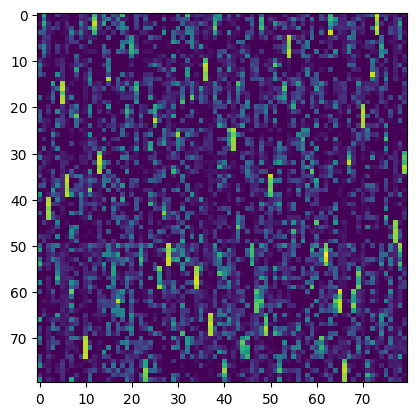

(80, 16)


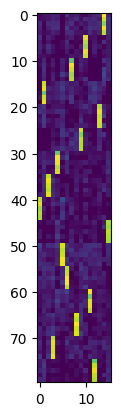

(80, 80)
(80,)


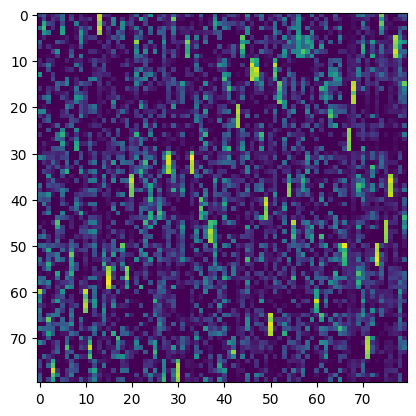

(80, 16)


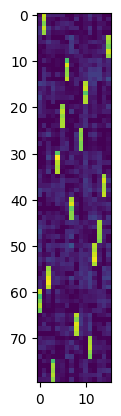

(80, 80)
(80,)


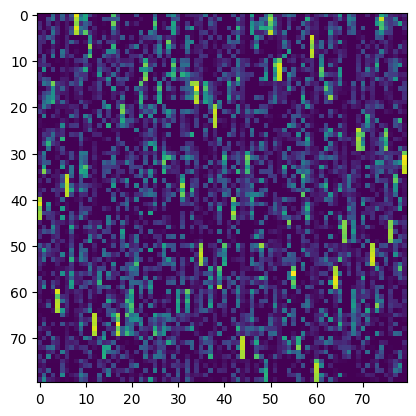

(80, 16)


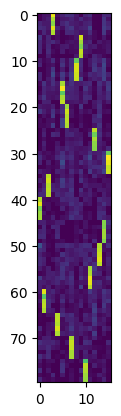

(80, 80)
(80,)


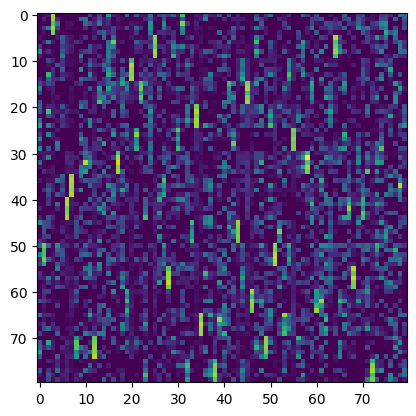

(80, 15)


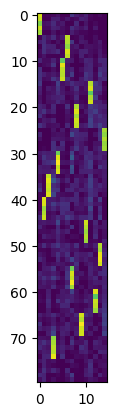

(80, 80)
(80,)


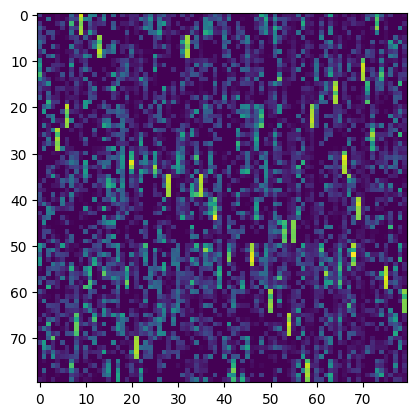

(80, 15)


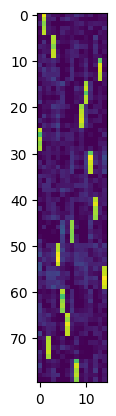

In [22]:
#activity_mask = n_active > 0.04
for w , mask in zip(f_oneshot, activity_mask):
    print(w.shape)
    print(mask.shape)
    plt.imshow(w)
    plt.show()
    w = w[:,mask]
    print(w.shape)
    plt.imshow(w)
    plt.show()

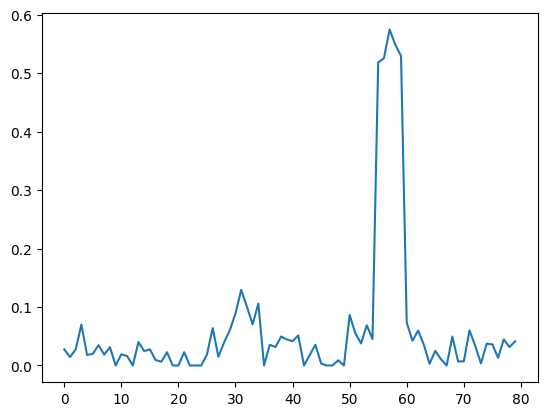

In [23]:
plt.plot(w[:,-1])

(80, 80)
(80,)


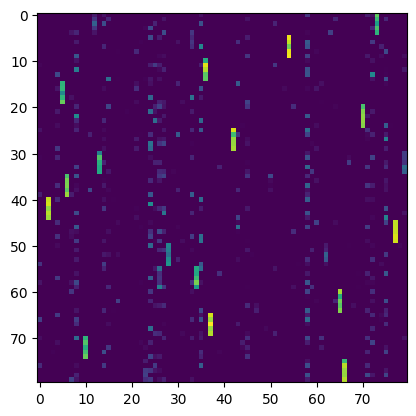

(80, 16)


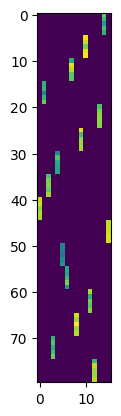

(80, 80)
(80,)


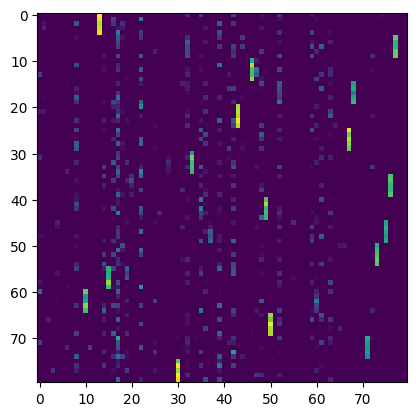

(80, 16)


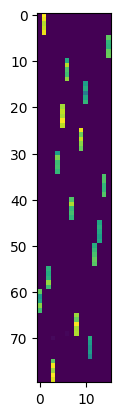

(80, 80)
(80,)


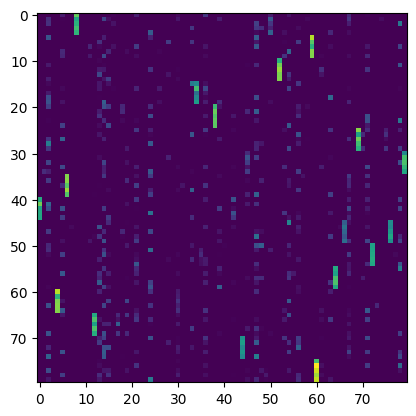

(80, 16)


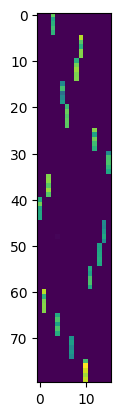

(80, 80)
(80,)


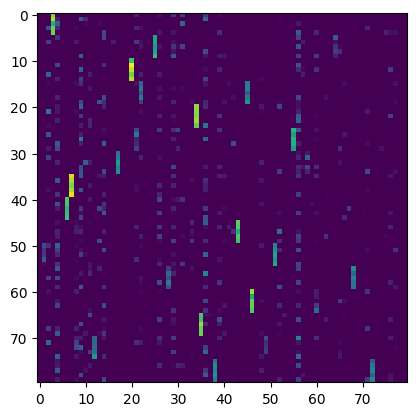

(80, 15)


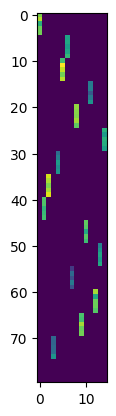

(80, 80)
(80,)


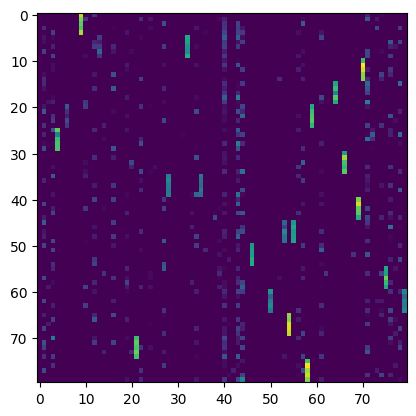

(80, 15)


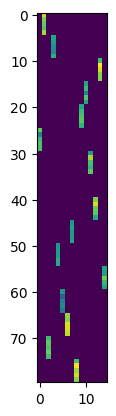

In [24]:
#activity_mask = n_active > 0.04
for w , mask in zip(acts.detach().numpy(), activity_mask):
    print(w.shape)
    print(mask.shape)
    plt.imshow(w)
    plt.show()
    w = w[:,mask]
    print(w.shape)
    plt.imshow(w)
    plt.show()

In [25]:
focus_mask = activity_mask[-1]
W_enc = SAE.W_enc[-1,:,focus_mask]
W_dec = SAE.W_dec[-1,focus_mask]
b_enc = SAE.b_enc[-1,focus_mask]
b_dec = SAE.b_dec[-1]

minimal_SAE_config = AutoEncoderConfig(1, W_enc.shape[0], W_enc.shape[1], l1_coeff = 0.01)

minimal_SAE = AutoEncoder(minimal_SAE_config)
minimal_SAE.W_enc = t.nn.Parameter(W_enc[None])
minimal_SAE.W_dec = t.nn.Parameter(W_dec[None])
minimal_SAE.b_enc = t.nn.Parameter(b_enc[None])
minimal_SAE.b_dec = t.nn.Parameter(b_dec[None])


complete_SAE_config = AutoEncoderConfig(1, SAE.W_enc.shape[1], SAE.W_enc.shape[2], l1_coeff = 0.01)
complete_SAE = AutoEncoder(complete_SAE_config)
complete_SAE.W_enc = t.nn.Parameter(SAE.W_enc[-1][None])
complete_SAE.W_dec = t.nn.Parameter(SAE.W_dec[-1][None])
complete_SAE.b_enc = t.nn.Parameter(SAE.b_enc[-1][None])
complete_SAE.b_dec = t.nn.Parameter(SAE.b_dec[-1][None])


In [26]:
batch_size = 10000
features = model.generate_batch(batch_size)
h = einops.einsum(
    features,
    model.W,
    "batch instances feats, instances hidden feats -> batch instances hidden",
)

In [27]:
l1_loss, l2_loss, loss, acts, h_reconstructed = minimal_SAE.forward(h)

compare_l1_loss, compare_l2_loss, compare_loss, compare_acts, compare_h_reconstructed = complete_SAE.forward(h)

In [28]:
l2_loss.mean()

tensor(0.0682, grad_fn=<MeanBackward0>)

In [29]:
compare_l2_loss.mean()

tensor(0.0081, grad_fn=<MeanBackward0>)

In [30]:
residuals = (compare_h_reconstructed - h).detach().numpy()[:,0,:]

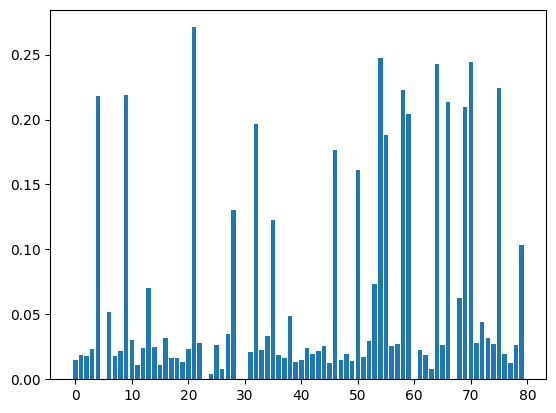

In [31]:
#make a bar chart of compare_acts.mean(0).detach().numpy()
activeation_avg = compare_acts.mean(0).detach().numpy()
plt.bar(range(activeation_avg.shape[1]), activeation_avg[0])
max_active_feature = np.argmax(activeation_avg)

h_eye = einops.rearrange(model.W, "a b c -> c a b")- complete_SAE.b_dec[None,:,:]
acts_eye = einops.einsum( h_eye, complete_SAE.W_enc,"feature instance compressed, instance compressed decompressed -> instance feature decompressed")
acts_eye = F.relu(acts_eye + complete_SAE.b_enc[None,:,None])[0]


response_of_max_feature = acts_eye[0,:,max_active_feature]
targeted_original_feature = [i for i in range(len(response_of_max_feature)) if response_of_max_feature[i]>.1]
h_targeted_representatios = h_eye[targeted_original_feature, 0,:]

acts_max_feature = t.zeros_like(acts_eye[:,:1,:])
acts_max_feature[0,0,max_active_feature] = 1	
h_max_feature = (
    einops.einsum(
        acts_max_feature,
        complete_SAE.normalize_and_return_W_dec(),
        "batch_size n_instances n_hidden_ae, n_instances n_hidden_ae n_input_ae -> batch_size n_instances n_input_ae",
    )
    + complete_SAE.b_dec
)

In [32]:
acts_eye.shape

torch.Size([1, 80, 80])

In [33]:
targeted_original_feature

[70, 71, 72, 73, 74]

In [34]:
compare_acts.shape

torch.Size([10000, 1, 80])

In [35]:
maxfeature_active_mask = compare_acts[:,0,max_active_feature]>0
print(maxfeature_active_mask.float().mean())

tensor(0.3320)


In [36]:
resid_active = residuals[maxfeature_active_mask]
resid_inactive = residuals[~maxfeature_active_mask]

In [37]:
pca1 = PCA(n_components=20)
pca1.fit(resid_active)
pca2 = PCA(n_components=20)
pca2.fit(resid_inactive)


PCA(n_components=20)

In [38]:
translation_matrix = pca2.components_*pca2.explained_variance_[:,None]
tranlated_basis = translation_matrix@pca1.components_

In [39]:
predicted_variances = np.sqrt((tranlated_basis**2).sum(0))
actual_variances = pca1.explained_variance_

In [40]:
h_targeted_representatios_mean = h_targeted_representatios.mean(0)
h_feature = h_max_feature[0]

h_targeted_representatios_mean = h_targeted_representatios_mean / h_targeted_representatios_mean.norm()
h_feature = h_feature / h_feature.norm()

for h in h_targeted_representatios:
    h = h / h.norm()
    #calculate and print cosine similarity
    print((h * h_feature).sum())
    print((h * h_targeted_representatios_mean).sum())
    print("")

tensor(0.4803, grad_fn=<SumBackward0>)
tensor(0.8338, grad_fn=<SumBackward0>)

tensor(0.5181, grad_fn=<SumBackward0>)
tensor(0.8326, grad_fn=<SumBackward0>)

tensor(0.5184, grad_fn=<SumBackward0>)
tensor(0.8246, grad_fn=<SumBackward0>)

tensor(0.5505, grad_fn=<SumBackward0>)
tensor(0.8257, grad_fn=<SumBackward0>)

tensor(0.4810, grad_fn=<SumBackward0>)
tensor(0.8372, grad_fn=<SumBackward0>)



In [41]:
h_feature_np = h_feature.detach().numpy()
h_targeted_representatios_diffs =np.array([h -(h*h_feature_np).sum()*h_feature_np for h in h_targeted_representatios.detach().numpy()])
h_targeted_representatios_diffs = h_targeted_representatios_diffs[:,0,:]
diffs_pca = PCA(n_components=5)
diffs_pca.fit(h_targeted_representatios_diffs)

diffs_variances_matrix = diffs_pca.components_*(diffs_pca.explained_variance_[:,None])
tranlated_diffs_variances_matrix = diffs_variances_matrix@pca1.components_
diffs_variances = np.sqrt((tranlated_diffs_variances_matrix**2).sum(0))

In [42]:
diffs_pca.explained_variance_.shape

diff_vecs = diffs_pca.components_[:3]

In [325]:
diff_vecs.shape

(3, 20)

In [43]:
def gram_schmidt(vectors):
    basis = []
    for v in vectors:
        w = v
        for b in basis:
            w = w - np.dot(v, b) / np.dot(b, b) * b
        if np.linalg.norm(w) > 1e-8:  # Tolerance for numerical stability
            basis.append(w / np.linalg.norm(w))
    return basis

def complete_basis(vectors, check_orthogonal = False):
    n = len(vectors)
    m = vectors[0].shape[0]
    if n >= m:
        raise ValueError("The number of vectors must be less than the dimension of the space.")

    # Ensure the input vectors are orthogonal
    if check_orthogonal:
        vectors = gram_schmidt(vectors)
    else:
        vectors = [v / np.linalg.norm(v) for v in vectors]

    # Generate additional random vectors
    for _ in range(m - n):
        v = np.random.rand(m)
        v = v - np.sum(np.dot(v, b) * b for b in vectors)
        v /= np.linalg.norm(v)
        vectors.append(v)

    return np.array(vectors)

In [44]:
completed_basis = complete_basis(diff_vecs)

C:\Users\wusch\AppData\Local\Temp\ipykernel_32380\4025350278.py:26: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  v = v - np.sum(np.dot(v, b) * b for b in vectors)


In [45]:
two_in_diff = completed_basis @  (pca2.components_*pca2.explained_variance_[:,None])
one_in_diff = completed_basis @  pca1.components_*pca1.explained_variance_[:,None]

In [46]:
overlap_matrix_2 = np.zeros((20,20))
for i in range(20):
    for j in range(20):
        overlap_matrix_2[i,j] = ((completed_basis[i] * pca2.components_[j])**2).sum()* pca2.explained_variance_[j]

overlap_matrix_1 = np.zeros((20,20))
for i in range(20):
    for j in range(20):
        overlap_matrix_1[i,j] = ((completed_basis[i] * pca1.components_[j])**2).sum() * pca1.explained_variance_[j]

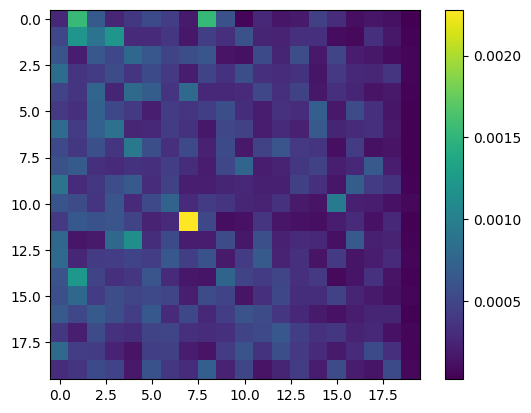

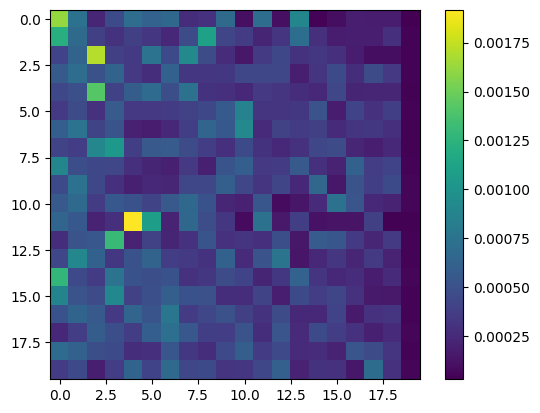

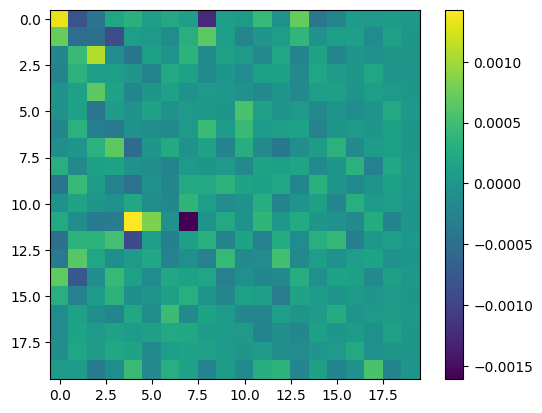

In [47]:
plt.imshow(overlap_matrix_2)
plt.colorbar()
plt.show()

plt.imshow(overlap_matrix_1)
plt.colorbar()
plt.show()

plt.imshow(overlap_matrix_1 - overlap_matrix_2)
plt.colorbar()
plt.show()

In [48]:
pca2.explained_variance_[:,None]

array([[0.01182213],
       [0.01092888],
       [0.01070603],
       [0.01034787],
       [0.00963433],
       [0.00921498],
       [0.00875384],
       [0.00864657],
       [0.00847082],
       [0.00794191],
       [0.00743057],
       [0.00732001],
       [0.00686521],
       [0.00679519],
       [0.00623102],
       [0.00603344],
       [0.00585402],
       [0.00543683],
       [0.00443281],
       [0.0009552 ]], dtype=float32)

In [49]:
two_in_diff

array([[-9.63482583e-04, -1.05638479e-03,  1.25241823e-03,
        -1.28813412e-05, -6.55878454e-05,  4.20492485e-04,
         3.69348264e-03, -1.67578367e-03, -2.37669459e-03,
        -3.63807652e-04, -2.01095038e-03,  1.91045335e-03,
        -4.96339080e-04, -9.38631919e-06, -6.02515778e-04,
        -9.55514986e-05, -6.73062921e-05, -3.93106516e-04,
        -2.69621532e-04,  9.89074504e-04],
       [-7.27419608e-04,  3.14039386e-04, -5.77890814e-04,
        -8.92807765e-04,  3.44256378e-03, -6.48376586e-05,
        -1.61508851e-03, -2.04869243e-04, -8.56250171e-04,
        -1.30892035e-03,  1.98786713e-03, -2.08262904e-05,
        -2.38571891e-03, -9.16835870e-04,  5.00776508e-05,
        -1.71849044e-03, -2.41924563e-03, -1.71399106e-03,
        -4.02675885e-03,  2.01146659e-03],
       [-1.61800728e-03,  2.15406685e-03, -3.02443647e-03,
         2.08095211e-03, -2.14212600e-03,  1.48540023e-03,
         3.54131079e-04,  1.88876268e-03, -1.01614106e-03,
        -1.24876803e-03, -7.9

In [353]:
two_in_diff

array([[ 8.23050813e-04,  6.83732577e-04, -2.61232952e-04,
        -3.66816264e-03,  2.20305552e-03,  3.67485433e-03,
         3.42779347e-03, -7.18296046e-04,  1.01893434e-03,
         5.45127181e-04,  5.00300045e-03,  1.63362845e-03,
        -6.32104364e-04, -5.07586390e-05, -5.18614893e-05,
        -3.98159180e-03,  5.27324910e-04,  4.51130230e-04,
        -1.25907718e-03, -5.59109094e-03],
       [-2.84821320e-04, -2.69569022e-03, -2.04987495e-03,
         1.35212613e-03,  2.21206508e-03, -2.73803445e-03,
         3.64006431e-03,  4.88585693e-04,  5.05051473e-03,
         3.89104454e-04,  4.76036441e-04, -2.73537294e-03,
        -1.63791355e-03,  3.77634139e-03, -2.46799283e-03,
         1.40107598e-03,  3.24293143e-03,  2.10858968e-04,
         5.88148440e-04,  2.95179868e-05],
       [-4.40656241e-03, -1.63140563e-03,  1.34402316e-03,
         2.66905999e-03,  1.64774746e-03,  2.58253349e-04,
         1.15015714e-03, -2.40317783e-03, -2.26003742e-03,
         5.86877329e-03,  1.9

In [50]:
diff_vecs.shape

(3, 20)

In [51]:
transfomrmed_diff_vecs = pca1.transform(diff_vecs)

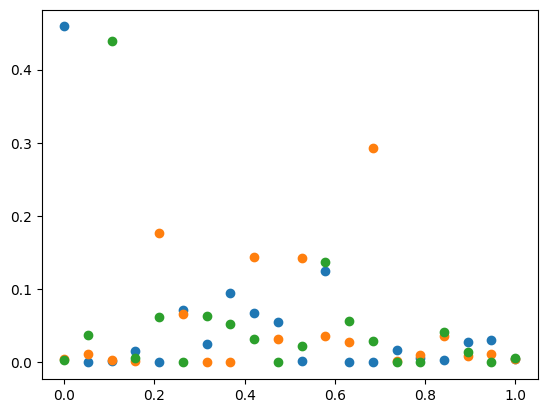

In [52]:
for dv in transfomrmed_diff_vecs:
    plt.scatter(np.linspace(0,1,20),dv**2)

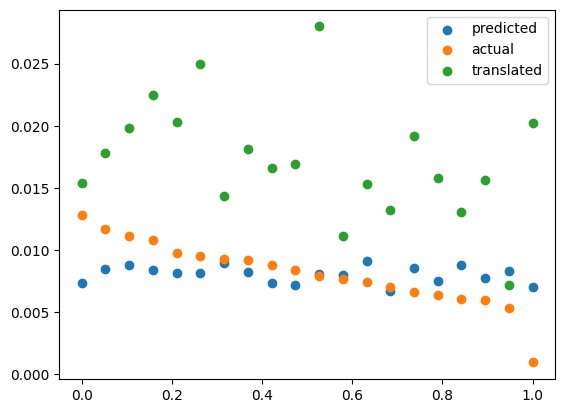

In [53]:
plt.scatter(np.linspace(0,1,20), predicted_variances, label = "predicted")
plt.scatter(np.linspace(0,1,20), actual_variances, label = "actual")
plt.scatter(np.linspace(0,1,20), diffs_variances, label = "translated")
plt.legend()


In [70]:
pca1.explained_variance_

array([0.01748425, 0.01342142, 0.01205051, 0.0097122 , 0.00731559,
       0.00693717, 0.00645401, 0.0058294 , 0.0057265 , 0.00527106,
       0.00482367, 0.0043639 , 0.00377435, 0.00363549, 0.00346051,
       0.00331124, 0.00283447, 0.0026156 , 0.00223399, 0.00184839],
      dtype=float32)

In [63]:
pca1.explained_variance_**2

array([3.05698864e-04, 1.80134637e-04, 1.45214886e-04, 9.43268969e-05,
       5.35178697e-05, 4.81242932e-05, 4.16543044e-05, 3.39819089e-05,
       3.27927628e-05, 2.77840772e-05, 2.32677685e-05, 1.90436203e-05,
       1.42456975e-05, 1.32167952e-05, 1.19751194e-05, 1.09642970e-05,
       8.03423700e-06, 6.84137012e-06, 4.99071530e-06, 3.41656096e-06],
      dtype=float32)

In [ ]:
pca1.transform(pca2.)

In [64]:
np.sqrt((translation_matrix**2).sum(0))

array([0.01748425, 0.01342143, 0.01205051, 0.0097122 , 0.00731559,
       0.00693717, 0.00645402, 0.0058294 , 0.0057265 , 0.00527106,
       0.00482367, 0.0043639 , 0.00377435, 0.00363549, 0.00346051,
       0.00331124, 0.00283447, 0.0026156 , 0.00223399, 0.00184839],
      dtype=float32)

In [51]:
pca2.components_.shape

(20, 20)

In [46]:
active_on_active = pca1.transform(resid_active)
inactive_on_active = pca1.transform(resid_inactive)
active_on_inactive = pca2.transform(resid_active)
inactive_on_inactive = pca2.transform(resid_inactive)

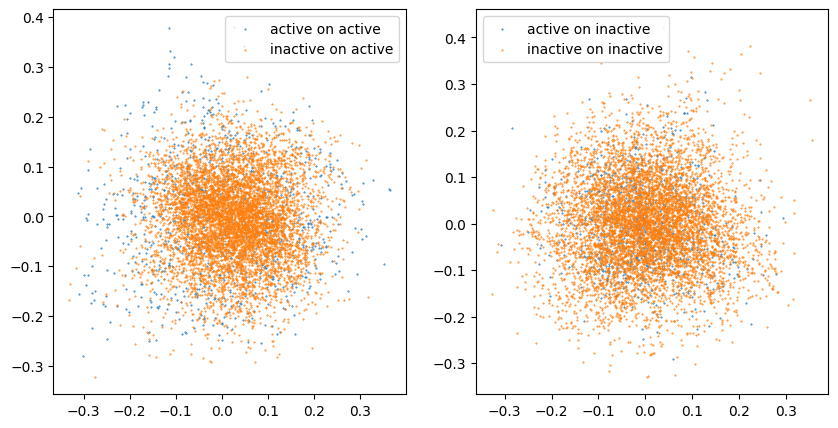

In [47]:
fig,axs = plt.subplots(1,2, figsize = (10,5))
axs[0].scatter(active_on_active[:,0], active_on_active[:,1], label = "active on active", s = .2)
axs[0].scatter(inactive_on_active[:,0], inactive_on_active[:,1], label = "inactive on active", s = .2)
axs[1].scatter(active_on_inactive[:,0], active_on_inactive[:,1], label = "active on inactive", s = .2)
axs[1].scatter(inactive_on_inactive[:,0], inactive_on_inactive[:,1], label = "inactive on inactive", s = .2)
axs[0].legend()
axs[1].legend()


In [213]:
max_active_feature

31

In [198]:
residuals.shape

(10000, 20)

In [54]:
feature_residual_no_sae = t.abs(features - reconstructed_features_no_sae)
feature_residual_with_sae = t.abs(features - reconstructed_features_with_sae)
difference_of_reconstructions = t.abs(reconstructed_features_no_sae - reconstructed_features_with_sae)
avg_resid_no_sae = feature_residual_no_sae.mean(0).detach().numpy()
avg_resid_with_sae = feature_residual_with_sae.mean(0).detach().numpy()

diff_avg_resid = difference_of_reconstructions.mean(0).detach().numpy()

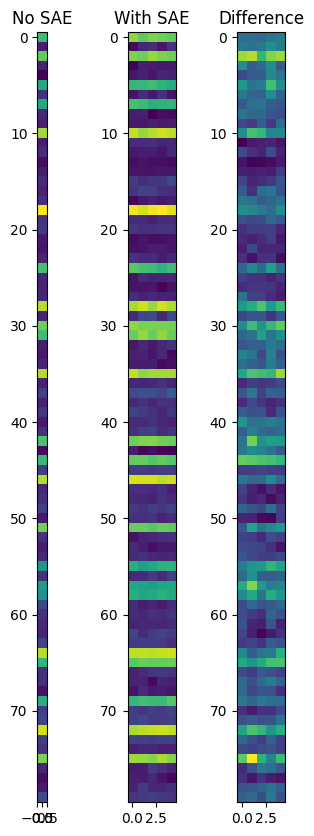

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(4, 10))
axs[0].imshow(avg_resid_no_sae.T)
axs[0].set_title("No SAE")
axs[1].imshow(avg_resid_with_sae.T)
axs[1].set_title("With SAE")
axs[2].imshow(diff_avg_resid.T)
axs[2].set_title("Difference")
plt.show()
